<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/decoder_smiles_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.9 MB/s eta 0:00:00


In [2]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

In [3]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In your google drive, there should be a `chembl_33_data.tar.gz` file. Locate that in the files tab on the left and copy and paste it's path into the line below.

 ### e.g. If the file pathway is `/content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz` the the code below will look this this:

 ### `!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/`

In [4]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [5]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [6]:
new_df = df[df['num_lipinski_ro5_violations'] < 1]

In [7]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

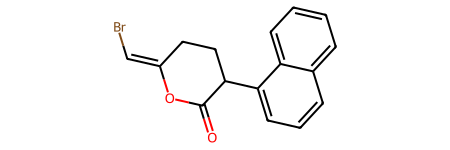

In [8]:
Chem.MolFromSmiles(df['canonical_smiles'].iloc[1])

In [9]:
(new_df['canonical_smiles'].iloc[0])

'O=C1O/C(=C/Br)CCC1c1cccc2ccccc12'

In [10]:
new_df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

In [11]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

In [12]:
wanted_values = ['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50']

In [14]:
lip_df = new_df[(new_df['num_lipinski_ro5_violations'] == 0) & (new_df['hba_lipinski'] <= 10) & (new_df['mw_monoisotopic'] < 480) & (new_df['le']>0.3) & (new_df['lle']>3)]
print(lip_df.shape)
lip_df.head()



(118542, 38)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0000,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
5,31,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,325753,IC50,0.5129,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.66,433.2114,8.0,2.0,0.0,-0.89,21.43,0.40,6.61,9.90
6,33,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,343861,IC50,33.8800,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,435.1035,9.0,2.0,0.0,-1.78,17.15,0.35,5.67,6.74
20,59,COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC,331005,IC50,3.3880,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,421.2114,8.0,2.0,0.0,-0.91,20.10,0.37,5.96,9.03
21,60,COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...,331003,IC50,3.3880,nM,33574,104304,CHEMBL1907610,Rattus norvegicus,...,0.57,449.2063,9.0,2.0,0.0,-0.67,18.84,0.35,5.87,8.22


Epoch 1/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 664s 742ms/step - accuracy: 0.8237 - loss: 0.6182 - val_accuracy: 0.9082 - val_loss: 0.2701
Epoch 2/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 241s 261ms/step - accuracy: 0.9090 - loss: 0.2671 - val_accuracy: 0.9213 - val_loss: 0.2266
Epoch 3/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 208s 269ms/step - accuracy: 0.9183 - loss: 0.2361 - val_accuracy: 0.9253 - val_loss: 0.2145
Epoch 4/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 196s 261ms/step - accuracy: 0.9229 - loss: 0.2213 - val_accuracy: 0.9285 - val_loss: 0.2044
Epoch 5/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 200s 269ms/step - accuracy: 0.9255 - loss: 0.2131 - val_accuracy: 0.9310 - val_loss: 0.1975
Epoch 6/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 200s 270ms/step - accuracy: 0.9277 - loss: 0.2064 - val_accuracy: 0.9321 - val_loss: 0.1940
Epoch 7/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 202s 269ms/step - accuracy: 0.9291 - loss: 0.2021 - val_accuracy: 0.9335 - val_loss: 0.1899
Epoch 8/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 202s 269ms/step - accuracy: 0.9306 -

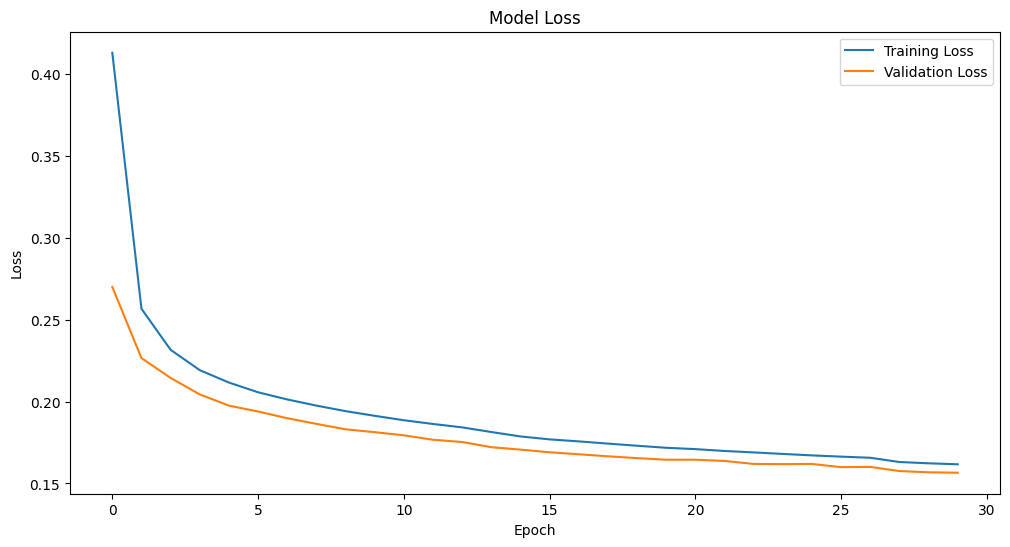

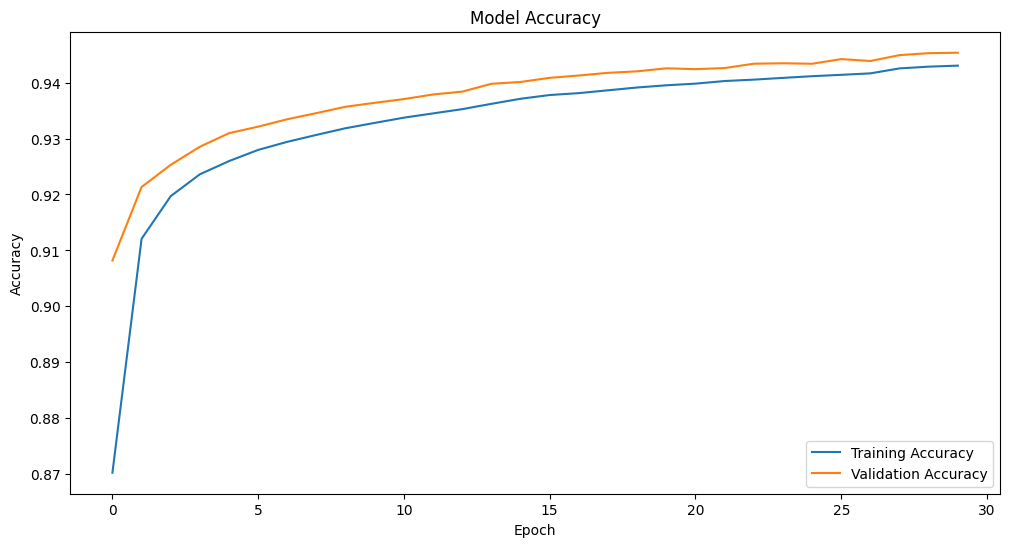

In [15]:
# Decoder only

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 128  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 8
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Example SMILES list (assuming lip_df is defined elsewhere)
smiles_list = lip_df['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in smiles_list
]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the GPT-like decoder-only model
def build_decoder_only_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        # Decoder block
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x, attention_mask=tf.linalg.band_part(tf.ones((input_shape[0], input_shape[0])), -1, 0))
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)
    model = Model(inputs, outputs)
    return model

# Instantiate the model
decoder_only_model = build_decoder_only_model(
    input_shape=(max_length,),
    vocab_size=len(vocab),
    model_dim=MODEL_DIM,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT,
    num_layers=NUM_LAYERS
)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

decoder_only_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = decoder_only_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [34]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique_smiles = list(set(valid_smiles))
    not_unique = 0
    for smiles in smiles_in_training:
      if smiles in unique_smiles:
        not_unique += 1

    # percent unique = number found in training set - unique smiles / total valid smiles
    unique = (len(unique_smiles)-not_unique)/len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

N#Cc1cc(N2CCNCC2)ccc1O
Generated SMILES: N#Cc1cc(N2CCNCC2)ccc1O


  1%|          | 1/100 [00:03<06:27,  3.92s/it]

CCCN1CCC(COc2ncc(COc3noc4cc(F)ccc34)c3cccc23)CC1


  2%|▏         | 2/100 [00:07<05:45,  3.52s/it]

Nc1nc2c(nc3ccc(/C=C/Br)cc13)CCC(CCc1ccccc1)C2


  3%|▎         | 3/100 [00:10<05:44,  3.55s/it]

CC(C)N1CCCC1COc1cncc(-c2ccc3[nH]nc(CC4CC4)c3c2)c1


  4%|▍         | 4/100 [00:12<04:51,  3.03s/it]

C[C@H](NC(=O)C(N)=O)C(=O)O


  5%|▌         | 5/100 [00:15<04:28,  2.83s/it]

N=C(N)N/N=C/c1c(O)nsc1Cl


  6%|▌         | 6/100 [00:18<04:37,  2.95s/it]

Cc1ccccc1S(=O)(=O)Nc1nnc(Cc2ccccn2)s1


  7%|▋         | 7/100 [00:19<03:35,  2.32s/it]

OCCNCc1cccnc1


  8%|▊         | 8/100 [00:21<03:06,  2.02s/it]

CCCn1cnc2c(N)ncnc21


  9%|▉         | 9/100 [00:24<03:32,  2.34s/it]

COc1ccccc1N1CCN(CCCCNC(=O)c2cc3ccccc3s2)CC1


 10%|█         | 10/100 [00:27<04:02,  2.69s/it]

CC(=O)N(O)C[C@H]1C(=O)Nc2cc(C)cc(Oc3ccncc3)c21


 11%|█         | 11/100 [00:31<04:32,  3.06s/it]

O=C([C@@H]1C[C@H](Nc2ccccc2Cl)CN1)N1CCSC1


 12%|█▏        | 12/100 [00:37<05:35,  3.82s/it]

Cc1ccc2oc(=O)cc(C[C@H]3C[C@H]3NC(=O)C[C@@H]3CCCN3C2c3ccccc3C(F)(F)F)c2c1


 13%|█▎        | 13/100 [00:40<05:16,  3.64s/it]

O=C1CC2(CCCCC2)CC(=O)N1CCN1CCN(c2ccc(F)cc2)CC1


 14%|█▍        | 14/100 [00:42<04:43,  3.30s/it]

CC1(C)/C(=N/c2ccc(N)cc2)C(=O)NNC1=O


 15%|█▌        | 15/100 [00:45<04:29,  3.17s/it]

CCCN1C[C@@H]2CCCN2Cc2cccc(O)c21


 16%|█▌        | 16/100 [00:48<04:22,  3.13s/it]

OCCCNC1CCN(Cc2ccc3(c2)OCO3)CC1


 17%|█▋        | 17/100 [00:52<04:46,  3.45s/it]

O=C(Nc1ccccc1Cl)C1CCC(Nc2ncc(Cl)c(Nc3cncnc3Nc3ccccc3)n2)CC1


 18%|█▊        | 18/100 [00:55<04:14,  3.11s/it]

O=S(=O)(NCCCc1ccccc1)c1cccc(O)c1


 19%|█▉        | 19/100 [00:58<04:08,  3.07s/it]

COc1ccccc1N1CCN(Cc2cc(C3CC3)oc2CC(N)=O)CC1


 20%|██        | 20/100 [01:00<03:55,  2.95s/it]

NC(=O)c1cccc2c(S(N)(=O)=O)cccc12


 21%|██        | 21/100 [01:03<03:42,  2.82s/it]

COc1ccc(OC)c(CCNC(C)=O)c1


 22%|██▏       | 22/100 [01:06<03:44,  2.88s/it]

O=C(NCCc1ccc(O)cc1)c1cc2ccc(O)cc2o1


 23%|██▎       | 23/100 [01:09<03:36,  2.81s/it]

CC(C)Cn1c(=O)n(C)c(=O)c2c(N)nc(Cl)nc21


 24%|██▍       | 24/100 [01:11<03:31,  2.78s/it]

CCOC(=O)CCCC1=C(c2ccc(C)cc2)C(=O)NC1=O


 25%|██▌       | 25/100 [01:15<03:43,  2.99s/it]

O=C(NO)[C@@]1(O)CCC[C@H]1Sc1ccc(Oc2ccc(F)cc2F)cc1


 26%|██▌       | 26/100 [01:16<03:10,  2.57s/it]

CN1CCC=C/c2ccccc21


 27%|██▋       | 27/100 [01:20<03:42,  3.05s/it]

Cc1noc(C)c1Cc1c(N)ncnc1OC(c1ccccc1)c1ccccc1


 28%|██▊       | 28/100 [01:23<03:29,  2.92s/it]

Cc1c(/N=C2\SC(=O)NC2=O)sc2cc(O)ccc12


 29%|██▉       | 29/100 [01:26<03:30,  2.97s/it]

CN1C(=O)C(c2ccc(-c3ccncc3)cc2)(c2ccccc2)N=C1N


 30%|███       | 30/100 [01:29<03:34,  3.06s/it]

O=C(C(=O)c1ccc(Cl)s1)c1ccc(F)cc1O.O=C(O)c1ccccc1


 31%|███       | 31/100 [01:33<03:46,  3.28s/it]

CNC(=O)Cn1c(=O)n(C2CCN(CC3CC3)CC2)c2ccccc21


 32%|███▏      | 32/100 [01:37<04:00,  3.53s/it]

Cc1c(OCCc2c[nH]cn2)nn2c(N)nc(C#Cc3ccccc3)nc12


 33%|███▎      | 33/100 [01:39<03:12,  2.87s/it]

C[C@H][C@H]1CCCN1C


 34%|███▍      | 34/100 [01:41<02:52,  2.62s/it]

CC(C)N(C)C(=O)Nc1ccnc2ccccc12


 35%|███▌      | 35/100 [01:45<03:25,  3.16s/it]

Cc1cc([C@H]2CC[C@]23CCCC3)ccc1O(C)CC(N1CCCC1)CC2(c1ccccc1)N1CCCCC1


 36%|███▌      | 36/100 [01:47<02:57,  2.78s/it]

N1C(=O)[C@@H]2CC[C@H]1CO2


 37%|███▋      | 37/100 [01:51<03:12,  3.06s/it]

CC(C)Nc1nc2ccc(S(C)(=O)=O)cn2c2c1ncn2C


 38%|███▊      | 38/100 [01:54<03:11,  3.09s/it]

C[C@H]1CN(Cc2cccs2)CC[C@@]1(C)c1ccccc1


 39%|███▉      | 39/100 [01:57<03:13,  3.17s/it]

CC1=CC2CC[C@@H]3c4ccc(O)c(O)c4CC[C@@]3(C1)[C@H]2O


 40%|████      | 40/100 [01:59<02:44,  2.74s/it]

COc1cccc2c1C(CCN(C)C)CC2


 41%|████      | 41/100 [02:01<02:26,  2.49s/it]

CC12CCc3[nH]nc(CO)c3CC1CCC2


 42%|████▏     | 42/100 [02:03<02:24,  2.49s/it]

Cl.O=C(Cc1ccc(O)cc1)Nc1ccc(O)cc1


 43%|████▎     | 43/100 [02:08<02:57,  3.11s/it]

NC(=O)c1cnc(NC2CCCc3cc(O)c(O)cc32)c2cc(O)ccc12


 44%|████▍     | 44/100 [02:12<03:12,  3.44s/it]

Nc1cc(CN2CCC(NC(=O)Nc3ccccc3OCc3cnnn3Cc3ccc(Cl)cc3)CC2)ccn1


 45%|████▌     | 45/100 [02:15<02:56,  3.20s/it]

OCCC[C@H](NCc1ccccc1)C(=O)NCc1cccc(F)c1


 46%|████▌     | 46/100 [02:17<02:36,  2.90s/it]

Cc1cccc(Sc2ccccc2N2CCNCC2)c1.Cl


 47%|████▋     | 47/100 [02:19<02:27,  2.79s/it]

O=C1SC2(CCCC2)[C@](SCc2ccccc2)=N1


 48%|████▊     | 48/100 [02:23<02:37,  3.04s/it]

NC(=O)c1cccc(-c2ccc(-c3ccnc(N)c3)o2)c1


 49%|████▉     | 49/100 [02:27<02:41,  3.17s/it]

Cc1ccccc1N1CCN(CCCCSc2nc(C3CC3)nc(N)n2)CC1


 50%|█████     | 50/100 [02:30<02:47,  3.34s/it]

COc1ccccc1N1CCN(CCCNC(=O)c2cccc(CN3CCC[C@H]3CC)c2)CC1


 51%|█████     | 51/100 [02:33<02:34,  3.16s/it]

O=C(OCc1ccc(Cl)cc1Cl)N1CCc2nc(Cl)cnc2C1


 52%|█████▏    | 52/100 [02:36<02:26,  3.05s/it]

O=C1NCN(c2ccccc2)C12CCN(C1CCCCC1)CC2


 53%|█████▎    | 53/100 [02:38<02:12,  2.81s/it]

COc1ccc(S(N)(=O)=O)cc1


 54%|█████▍    | 54/100 [02:42<02:19,  3.04s/it]

N#C[C@@H]1CCCN1C(=O)[C@@H]1C=Cc2cc(Cl)ccc2N1


 55%|█████▌    | 55/100 [02:45<02:17,  3.06s/it]

COc1ccc2c(CCCCN3CCC(c4noc5ccccc45)CC3)cccc2c1


 56%|█████▌    | 56/100 [02:49<02:25,  3.31s/it]

COc1cc2c(cc1OC)C1=NOC(CN3CCN(C/C=C/c4cncc(C#N)c4)CC3)C1CO2


 57%|█████▋    | 57/100 [02:55<03:00,  4.20s/it]

CC1(C)CC(C(=O)N(CCC(F)(F)F)[C@@H]2Cc2ccccc2)C[C@H]2C[C@H](NC3=O)CC[C@H]21


 58%|█████▊    | 58/100 [02:59<02:58,  4.25s/it]

Fc1ccc(C2(c3ccc4[nH]ncc4c3)N=C(N3)N=C2NCCCCCCCCCCCOC=O)cc1


 59%|█████▉    | 59/100 [03:03<02:45,  4.03s/it]

NS(=O)(=O)c1ccc(NS(=O)(=O)c2c(F)c(F)c(F)c(F)c2F)cc1


 60%|██████    | 60/100 [03:06<02:25,  3.63s/it]

O=C1c2ccc(O)cc2C(=O)N1Cc1ccc(Cl)c(Cl)c1


 61%|██████    | 61/100 [03:09<02:16,  3.50s/it]

Nc1cc2c(cc1C(=O)NCc1ccccn1)CC(=O)N2


 62%|██████▏   | 62/100 [03:11<02:01,  3.21s/it]

CC1(C)[C@H]2CCC(C1)N2CCF


 63%|██████▎   | 63/100 [03:15<02:03,  3.33s/it]

CC(C)[C@H](NS(=O)(=O)c1ccc(-c2cnn(C)n2)cc1)C(=O)NO


 64%|██████▍   | 64/100 [03:18<01:57,  3.25s/it]

CCNc1ccc(S(=O)(=O)N2CCC[C@H]2C(=O)N2CCNCC2)cc1


 65%|██████▌   | 65/100 [03:20<01:44,  2.99s/it]

O=C1c2cc(Oc3ccccc3)ccc2CCc2ccccc21


 66%|██████▌   | 66/100 [03:26<02:08,  3.78s/it]

Cc1ccc(S(=O)(=O)N2CCC(NC34CC5CC(CC(C5)C3)C4)CC2)c2c1CCC[C@@H]2C1=O


 67%|██████▋   | 67/100 [03:29<02:02,  3.71s/it]

c1ccc(-c2nc3cc4ccccc4nc-3c(N3CCOCC3)n2)cc1


 68%|██████▊   | 68/100 [03:31<01:38,  3.08s/it]

Nc1ccc(C(=O)c2ccsc2)cc1


 69%|██████▉   | 69/100 [03:36<01:47,  3.48s/it]

COc1cc2[nH]c(=O)n(CC(=O)O)nc2cc1CCC(=O)OC(C)(C)CC.O=C(O)C(F)(F)F


 70%|███████   | 70/100 [03:40<01:52,  3.76s/it]

Cc1ccccc1-c1ccccc1C(=O)N1CCC[C@H]1C(=O)NCC1CCN(C2CCC2)CC1


 71%|███████   | 71/100 [03:43<01:39,  3.45s/it]

Cc1c(NC2=NCCN2)ccc(Br)c1C#N


 72%|███████▏  | 72/100 [03:46<01:38,  3.52s/it]

CCC#CCOc1cc(C2OC(CO)(CC(=O)O)C(=O)O2)cc(C=O)c1OC


 73%|███████▎  | 73/100 [03:49<01:28,  3.27s/it]

COc1cccc(-n2cncc2CSCC[C@@H](N)C(=O)O)c1


 74%|███████▍  | 74/100 [03:52<01:22,  3.18s/it]

CCCCCN1Cc2ccccc2N(CC(=O)N(CCC)Cc2ccccc2)C1=O


 75%|███████▌  | 75/100 [03:55<01:21,  3.26s/it]

CCOC(=O)c1cnc(Nc2cc(-c3cccnc3)ccc2N2CCNCC2)s1


 76%|███████▌  | 76/100 [03:58<01:15,  3.15s/it]

COc1ccccc1N1CCN(CCc2ccccc2)CC1


 77%|███████▋  | 77/100 [04:02<01:13,  3.18s/it]

COc1ccc2c(c1)CCCN2C(=O)C1CCN(c2ccccn2)CC1


 78%|███████▊  | 78/100 [04:03<01:01,  2.80s/it]

CCCN1Cc2ccc(Cl)c(OC)c2CC1CN


 79%|███████▉  | 79/100 [04:05<00:53,  2.54s/it]

COc1ccccc1C(c1ccccc1)N1CCNCC1


 80%|████████  | 80/100 [04:08<00:53,  2.68s/it]

CCCCCCCCN1CC[C@@]2(C)c3ccccc3C[C@@H]1[C@@H]2C


 81%|████████  | 81/100 [04:10<00:42,  2.21s/it]

NC1=Nc2ccccc2CC1


 82%|████████▏ | 82/100 [04:13<00:46,  2.59s/it]

O=C(CC1CCN(Cc2cccc(OC(F)(F)F)c2)CC1)NO


 83%|████████▎ | 83/100 [04:17<00:50,  2.99s/it]

Br.Cc1ccc(CN2CCC(Nc3ccc(-c4cn[nH]c4)cc3)CC2)cc1


 84%|████████▍ | 84/100 [04:19<00:43,  2.72s/it]

N=C(N)NCCC1CCN(Cc2ccccc2Cl)CC1


 85%|████████▌ | 85/100 [04:21<00:39,  2.63s/it]

CS(=O)(=O)c1ccc(CCCNC(=O)c2cccs2)cc1


 86%|████████▌ | 86/100 [04:25<00:38,  2.77s/it]

N[C@H]1CC[C@H](Nc2nc(Sc3ccc4c(c3)OCCO4)ns2)CC1


 87%|████████▋ | 87/100 [04:29<00:40,  3.15s/it]

O=C1CC2(C(=O)N1)C(=O)N(c1ccc(F)cc1)C(=O)c1cccn12


 88%|████████▊ | 88/100 [04:33<00:41,  3.43s/it]

O=C(CCCCC(=O)N1CCSC1)N1CCC2(CC1)C(=O)N2c1ccc(F)cc1


 89%|████████▉ | 89/100 [04:35<00:33,  3.05s/it]

CCOC(=O)C[C@H]1c2ccccc2C[C@H]1N


 90%|█████████ | 90/100 [04:37<00:28,  2.86s/it]

CCN(CC)CCOc1cc(N2CCNC(=O)C2)ccc1C#N


 91%|█████████ | 91/100 [04:39<00:21,  2.43s/it]

NS(=O)(=O)c1ccc(F)cc1


 92%|█████████▏| 92/100 [04:42<00:21,  2.65s/it]

COc1ccc(Nc2c(Nc3cccc(C(N)=O)c3)c(=O)c2=O)cc1


 93%|█████████▎| 93/100 [04:45<00:18,  2.69s/it]

Cc1nc2ncc(-c3ccnc(N)n3)cn2c1C


 94%|█████████▍| 94/100 [04:48<00:17,  2.93s/it]

CCCCN1C(=O)C2C(C)NC(N3C(=O)c4ccccc4C3)C21


 95%|█████████▌| 95/100 [04:53<00:16,  3.40s/it]

CC[C@H](Nc1nc(Nc2cc3ccc(F)cc3o2)ncc1C(N)=O)C(=O)N(C)C


 96%|█████████▌| 96/100 [04:55<00:12,  3.06s/it]

O=c1[nH]c2c(ccc3cnoc23)c(=O)n1O


 97%|█████████▋| 97/100 [04:57<00:08,  2.72s/it]

Cc1cc(C)c2sc(CC(N)=O)cc2c1


 98%|█████████▊| 98/100 [05:01<00:06,  3.29s/it]

Nc1ccc(-c2ccc(S(=O)(=O)CC3(C(=O)NO)CCOCC3)o2)cc1


 99%|█████████▉| 99/100 [05:04<00:03,  3.08s/it]

CCn1c(CCc2ccccc2)nnc1-c1ccccc1


100%|██████████| 100/100 [05:06<00:00,  3.06s/it]

CC(OCCn1ncn2ncnc12)c1ccccc1

Percent valid: 91.000%
Percent unique: 100.000%
['CC(C)Cn1c(=O)n(C)c(=O)c2c(N)nc(Cl)nc21', 'COc1ccccc1N1CCN(CCc2ccccc2)CC1', 'NS(=O)(=O)c1ccc(NS(=O)(=O)c2c(F)c(F)c(F)c(F)c2F)cc1', 'CCn1c(CCc2ccccc2)nnc1-c1ccccc1', 'O=C(OCc1ccc(Cl)cc1Cl)N1CCc2nc(Cl)cnc2C1', 'O=C1c2ccc(O)cc2C(=O)N1Cc1ccc(Cl)c(Cl)c1', 'CCN(CC)CCOc1cc(N2CCNC(=O)C2)ccc1C#N', 'COc1cccc(-n2cncc2CSCC[C@@H](N)C(=O)O)c1', 'O=C(NO)[C@@]1(O)CCC[C@H]1Sc1ccc(Oc2ccc(F)cc2F)cc1', 'CCCN1C[C@@H]2CCCN2Cc2cccc(O)c21', 'CCCCN1C(=O)C2C(C)NC(N3C(=O)c4ccccc4C3)C21', 'CC(C)N1CCCC1COc1cncc(-c2ccc3[nH]nc(CC4CC4)c3c2)c1', 'CCOC(=O)C[C@H]1c2ccccc2C[C@H]1N', 'CCNc1ccc(S(=O)(=O)N2CCC[C@H]2C(=O)N2CCNCC2)cc1', 'COc1ccccc1N1CCN(CCCCNC(=O)c2cc3ccccc3s2)CC1', 'Nc1ccc(-c2ccc(S(=O)(=O)CC3(C(=O)NO)CCOCC3)o2)cc1', 'O=S(=O)(NCCCc1ccccc1)c1cccc(O)c1', 'CC(C)[C@H](NS(=O)(=O)c1ccc(-c2cnn(C)n2)cc1)C(=O)NO', 'Nc1cc2c(cc1C(=O)NCc1ccccn1)CC(=O)N2', 'CN1CCC=C/c2ccccc21', 'CCOC(=O)c1cnc(Nc2cc(-c3cccnc3)ccc2N2CCNCC2)s1', 'CCCCCCCCN1CC[C@@]2

In [17]:

decoder_only_model.save("/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TD_128_L8_H4.keras")

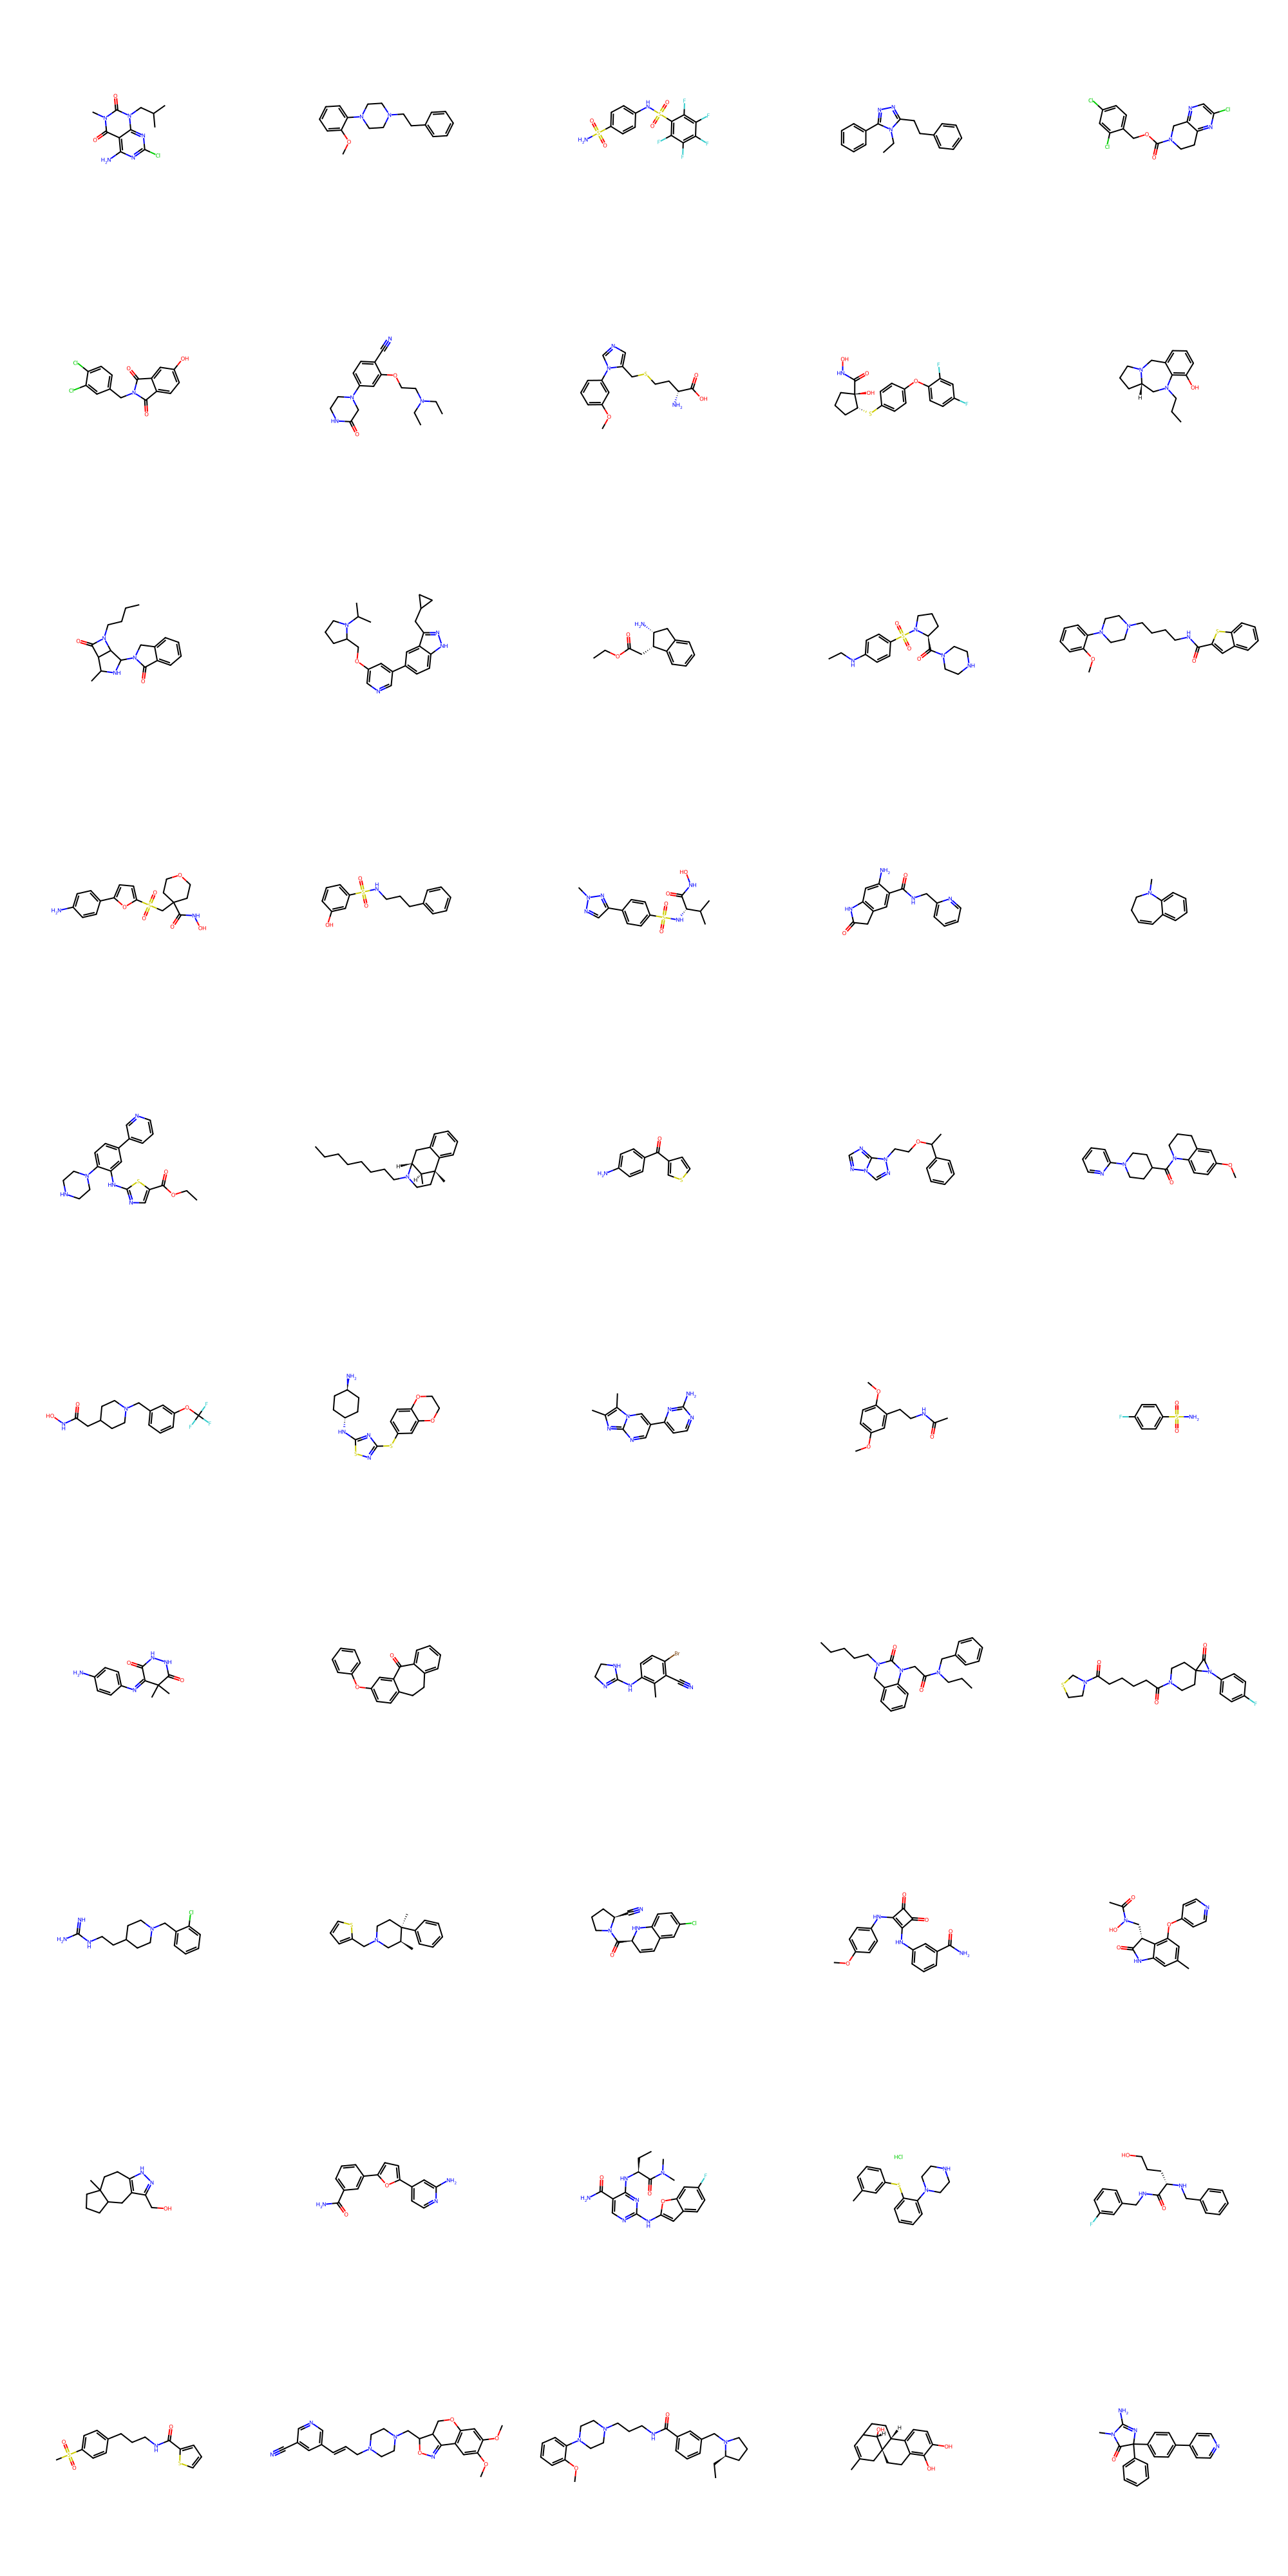

In [36]:
# Example: Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)